In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Investigación sobre capas CNN en PyTorch

### Conv2D
- **Entrada:** Tensores de imágenes en forma `(batch_size, canales, alto, ancho)`.
- **Parámetros principales:** 
  - `in_channels`: número de canales de entrada.
  - `out_channels`: número de filtros (mapas de características).
  - `kernel_size`: tamaño del filtro (ej. 3x3, 5x5).
  - `stride`: paso del filtro.
  - `padding`: borde agregado para conservar dimensiones.
- **Uso típico:** Extraer características locales (bordes, texturas, formas).

### MaxPool2D
- **Entrada:** Mapas de características de convolución.
- **Parámetros principales:**
  - `kernel_size`: tamaño de la ventana.
  - `stride`: paso del pooling.
- **Uso típico:** Reducir dimensionalidad y resaltar características más importantes.

### AvgPool2D
- **Entrada:** Mapas de características.
- **Parámetros principales:**
  - `kernel_size`, `stride`.
- **Uso típico:** Suavizar mapas de activación, menos agresivo que MaxPool.

### Normalización del dataset MNIST
Se puede aplicar `transforms.Normalize((0.1307,), (0.3081,))` ya que:
- La media de MNIST ≈ 0.1307
- La desviación estándar ≈ 0.3081  
Esto centra los datos en 0 y con varianza unitaria → mejora la convergencia y evita sobreajuste.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Capa convolucional 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        # Capa convolucional 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        # Capa fully connected
        self.fc1 = nn.Linear(64*7*7, 128)  
        self.fc2 = nn.Linear(128, 10)      

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*7*7)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

train(model, train_loader, optimizer, criterion, epochs=5)


Epoch 1/5, Loss: 0.1294
Epoch 2/5, Loss: 0.0401
Epoch 3/5, Loss: 0.0274
Epoch 4/5, Loss: 0.0200
Epoch 5/5, Loss: 0.0153


Test Accuracy: 99.14%


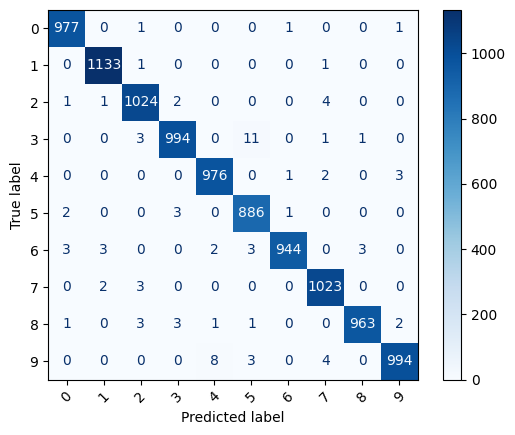

In [5]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    return all_preds, all_labels

preds, labels = evaluate(model, test_loader)

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()


Epoch 1/5, Loss: 0.2259
Epoch 2/5, Loss: 0.0913
Epoch 3/5, Loss: 0.0638
Epoch 4/5, Loss: 0.0499
Epoch 5/5, Loss: 0.0387
Test Accuracy: 97.53%


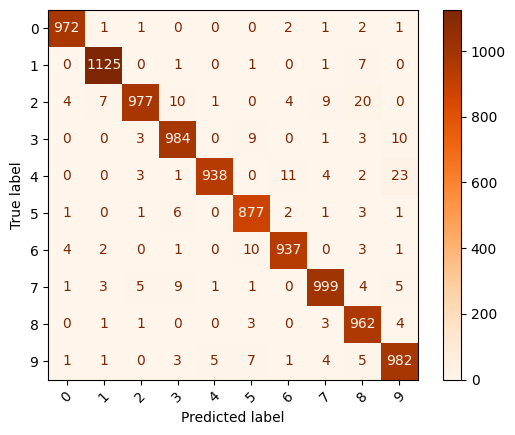

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mlp = MLP().to(device)
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.001)

# Entrenar MLP
train(mlp, train_loader, optimizer_mlp, criterion, epochs=5)

# Evaluar MLP
preds_mlp, labels_mlp = evaluate(mlp, test_loader)

cm_mlp = confusion_matrix(labels_mlp, preds_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=range(10))
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.show()


In [7]:
#Variar filtros y neuronas
class CNN_Exp(nn.Module):
    def __init__(self, filters1=32, filters2=64, hidden=128):
        super(CNN_Exp, self).__init__()
        self.conv1 = nn.Conv2d(1, filters1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(filters1, filters2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(filters2*7*7, hidden)
        self.fc2 = nn.Linear(hidden, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Combinaciones de filtros, neuronas y optimizadores
configs = [
    {"filters1": 16, "filters2": 32, "hidden": 64, "optimizer": "SGD"},
    {"filters1": 32, "filters2": 64, "hidden": 128, "optimizer": "Adam"},
    {"filters1": 64, "filters2": 128, "hidden": 256, "optimizer": "Adam"}
]

results = {}

for cfg in configs:
    print(f"\n🔹 Entrenando configuración: {cfg}")
    model_exp = CNN_Exp(cfg["filters1"], cfg["filters2"], cfg["hidden"]).to(device)
    criterion = nn.CrossEntropyLoss()
    if cfg["optimizer"] == "Adam":
        optimizer = optim.Adam(model_exp.parameters(), lr=0.001)
    else:
        optimizer = optim.SGD(model_exp.parameters(), lr=0.01, momentum=0.9)

    train(model_exp, train_loader, optimizer, criterion, epochs=3)
    preds, labels = evaluate(model_exp, test_loader)
    acc = sum([p==l for p,l in zip(preds,labels)]) / len(labels)
    results[str(cfg)] = acc

print("\n📊 Resultados experimentales:")
for k,v in results.items():
    print(f"{k}: {v:.4f}")



🔹 Entrenando configuración: {'filters1': 16, 'filters2': 32, 'hidden': 64, 'optimizer': 'SGD'}
Epoch 1/3, Loss: 0.2153
Epoch 2/3, Loss: 0.0545
Epoch 3/3, Loss: 0.0375
Test Accuracy: 98.94%

🔹 Entrenando configuración: {'filters1': 32, 'filters2': 64, 'hidden': 128, 'optimizer': 'Adam'}
Epoch 1/3, Loss: 0.1407
Epoch 2/3, Loss: 0.0413
Epoch 3/3, Loss: 0.0291
Test Accuracy: 98.99%

🔹 Entrenando configuración: {'filters1': 64, 'filters2': 128, 'hidden': 256, 'optimizer': 'Adam'}
Epoch 1/3, Loss: 0.1066
Epoch 2/3, Loss: 0.0355
Epoch 3/3, Loss: 0.0231
Test Accuracy: 99.05%

📊 Resultados experimentales:
{'filters1': 16, 'filters2': 32, 'hidden': 64, 'optimizer': 'SGD'}: 0.9894
{'filters1': 32, 'filters2': 64, 'hidden': 128, 'optimizer': 'Adam'}: 0.9899
{'filters1': 64, 'filters2': 128, 'hidden': 256, 'optimizer': 'Adam'}: 0.9905



 Entrenando MLP baseline
Epoch 1/5, Loss: 0.2299
Epoch 2/5, Loss: 0.0923
Epoch 3/5, Loss: 0.0672
Epoch 4/5, Loss: 0.0470
Epoch 5/5, Loss: 0.0439
Test Accuracy: 97.80%


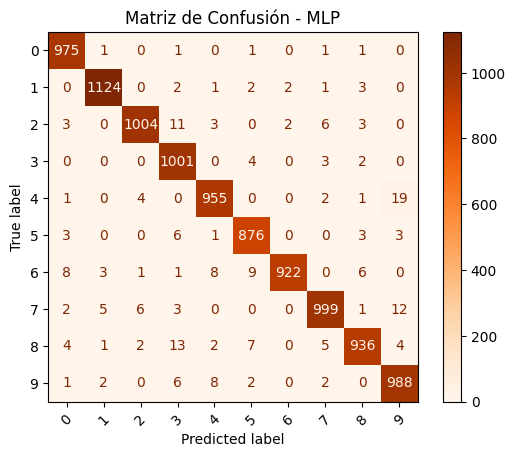

In [8]:
#Red base
class MLP(nn.Module):
    def __init__(self, hidden1=256, hidden2=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mlp = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp.parameters(), lr=0.001)

print("\n Entrenando MLP baseline")
train(mlp, train_loader, optimizer_mlp, criterion, epochs=5)
preds_mlp, labels_mlp = evaluate(mlp, test_loader)

# Matriz de confusión MLP
cm_mlp = confusion_matrix(labels_mlp, preds_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=range(10))
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.title("Matriz de Confusión - MLP")
plt.show()


Test Accuracy: 99.14%


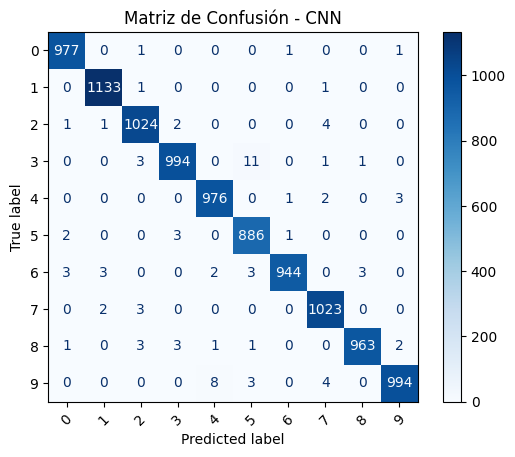


📊 Benchmark de modelos
CNN Accuracy: 0.9914
MLP Accuracy: 0.9780
Parámetros CNN: 421642
Parámetros MLP: 235146


In [9]:
# Evaluar CNN 
preds_cnn, labels_cnn = evaluate(model, test_loader)

cm_cnn = confusion_matrix(labels_cnn, preds_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=range(10))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusión - CNN")
plt.show()

# Comparación final
acc_cnn = sum([p==l for p,l in zip(preds_cnn, labels_cnn)]) / len(labels_cnn)
acc_mlp = sum([p==l for p,l in zip(preds_mlp, labels_mlp)]) / len(labels_mlp)

print("\n📊 Benchmark de modelos")
print(f"CNN Accuracy: {acc_cnn:.4f}")
print(f"MLP Accuracy: {acc_mlp:.4f}")
print(f"Parámetros CNN: {sum(p.numel() for p in model.parameters())}")
print(f"Parámetros MLP: {sum(p.numel() for p in mlp.parameters())}")
